# 02: Anomaly Detection (Traditional)

This notebook showcases approaches to anomaly detection without deep learning. These can be simpler to manage and understand at the price of being able to handle less complexity.

A challenge here stems from the nature of statistical outliers in package ecosystems; popular, well-structured, and well-documented repositories tend to be anomalous in their success.

Consequently, some feature transformations are needed to push models to instead identify less well-structured packages as anomalies.

> Note on **SourceRank**: This metric is a composite feature used by [libraries.io](https://libraries.io/api#project-sourcerank) to describe the quality of a project based on the presence of metadata, stars/forks, etc.
> 
> Although SourceRank is an opinionated metric and not suitable as a supervised learning target in this context, it is used here as a reference for sanity-checking the resulting anomaly scores.

## **Setup**

In [8]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

from data.load import load_and_verify_graph, merge_top_and_recent_graphs
from feature_engineering import add_structural_features

In [9]:
def run_anomaly_model(model_cls, model_params, feature_matrix, score_name, label_name):
    model = model_cls(**model_params)
    model.fit(feature_matrix)

    # Some models use decision_function, some use score_samples
    if hasattr(model, "decision_function"):
        scores = model.decision_function(feature_matrix)
    elif hasattr(model, "score_samples"):
        scores = model.score_samples(feature_matrix)
    else:
        raise AttributeError("Model does not have decision_function or score_samples.")
    
    # Some models use predict, some use fit_predict
    if hasattr(model, "predict"):
        preds = model.predict(feature_matrix)
    else:
        raise AttributeError("Model does not have predict method.")
    
    # -1 == anomaly for sklearn models
    is_anomaly = preds == -1
    return scores, is_anomaly

## **Load Data**

In [17]:
GRAPH_DATA_DIR = Path("../data/graph")
GRAPH_NAME_TOP = "graph_top_n200_20250717"
GRAPH_NAME_RECENT = "graph_recent_n200_20250717"

G_top, df_edges_top = load_and_verify_graph(GRAPH_NAME_TOP, GRAPH_DATA_DIR, print_summary=False)
G_recent, df_edges_recent = load_and_verify_graph(GRAPH_NAME_RECENT, GRAPH_DATA_DIR, print_summary=False)
G_merged = merge_top_and_recent_graphs(G_top, G_recent)

G_merged = add_structural_features(G_merged)

print(f"Number of nodes: {G_merged.number_of_nodes()}")
print(f"Number of edges: {G_merged.number_of_edges()}")
print(f"Example node data: {list(G_merged.nodes(data=True))[0]}")

Number of nodes: 1329
Number of edges: 3315
Example node data: ('opentelemetry-sdk', {'SourceRank': 21, 'stars': 2068, 'forks': 717, 'license': 'Apache-2.0', 'latest_release': '2025-07-11T12:23:24.000Z', 'num_optional_deps': 0, 'repo_url': 'https://github.com/open-telemetry/opentelemetry-python', 'has_repo': True, 'has_funding': False, 'num_keywords': 8, 'missing_metadata': False, 'core': True, 'sourcerank_missing': False, 'basic_info_present': 1, 'repository_present': 1, 'readme_present': 1, 'license_present': 1, 'versions_present': 1, 'follows_semver': 0, 'recent_release': 1, 'not_brand_new': 1, 'one_point_oh': 1, 'dependent_projects': 6, 'dependent_repositories': 3, 'contributors': 1, 'subscribers': 0, 'all_prereleases': 0, 'any_outdated_dependencies': 0, 'is_deprecated': 0, 'is_unmaintained': 0, 'is_removed': 0, 'is_copycat': True, 'is_recent': True, 'inter_intra_ratio': 2.0, 'clustering_coefficient': 0.1388888888888889, 'betweenness_centrality': 4.404267533461022e-06, 'degree_cent

In [ ]:
# Base features from the graph nodes, excluding "SourceRank" and some redundant ones
features = [
    "stars", "forks", "contributors",
    "dependent_projects", "dependent_repositories",
    "subscribers", "num_keywords", "num_optional_deps",
    "is_deprecated", "is_unmaintained", "is_removed", "is_copycat",
    "any_outdated_dependencies", "is_recent", "all_prereleases",
    "sourcerank_missing", "missing_metadata",
    "has_repo", "has_funding", "basic_info_present", "repository_present",
    "readme_present", "license_present", "versions_present", "recent_release",
    "not_brand_new", "one_point_oh",
    # Structural features
    "inter_intra_ratio", "clustering_coefficient", "betweenness_centrality",
    "degree_centrality", "closeness_centrality"
]

## **Define Pipeline**

In [127]:
def prepare_feature_matrix(G, features, with_structural=False, return_metadata=False):
    """
    Prepare input features for anomaly detection models.

    Applies transformations so that well-established repositories are less likely to be flagged as anomalies.
    Optionally includes structural features (with log transform) if with_structural=True.

    If return_metadata is True, also returns a DataFrame of all original node metadata for explainability.
    """
    node_items = list(G.nodes(data=True))
    node_ids = [node for node, _ in node_items]
    node_data = [data for _, data in node_items]
    df = pd.DataFrame(node_data)[features].fillna(0)

    # Positive indicators: more = better established
    positive_features = [
        "stars", "forks", "contributors", "dependent_projects", "dependent_repositories",
        "subscribers", "num_keywords", "num_optional_deps",
    ]
    for col in positive_features:
        if col in df.columns:
            df[f"{col}_log"] = np.log1p(df[col])

    # Negative indicators: invert so that good repos have HIGH values
    negative_features = [
        "is_deprecated", "is_unmaintained", "is_removed", "is_copycat",
        "any_outdated_dependencies", "is_recent", "all_prereleases",
        "sourcerank_missing", "missing_metadata"
    ]
    for col in negative_features:
        if col in df.columns:
            df[f"{col}_invert"] = 1 - df[col]

    # Binary indicators that are positive if present
    binary_positive_features = [
        "has_repo", "has_funding", "core", "basic_info_present", "repository_present",
        "readme_present", "license_present", "versions_present", "recent_release",
        "not_brand_new", "one_point_oh"
    ]
    for col in binary_positive_features:
        if col in df.columns:
            # Already 1/0, but ensure type and fillna
            df[col] = df[col].fillna(0).astype(int)

    # Create interpretable ratios that are HIGH for well-established repos
    if "forks" in df.columns and "stars" in df.columns:
        df["engagement_ratio"] = np.log1p(df["forks"]) / (np.log1p(df["stars"]) + 0.1)
    if "contributors" in df.columns and "dependent_projects" in df.columns:
        df["maintenance_ratio"] = np.log1p(df["contributors"]) / (np.log1p(df["dependent_projects"]) + 0.1)

    # Optionally add structural features (with log transform)
    structural_features = [
        "inter_intra_ratio", "clustering_coefficient", "betweenness_centrality",
        "degree_centrality", "closeness_centrality"
    ]
    structural_cols = []
    if with_structural:
        for col in structural_features:
            if col in df.columns:
                df[f"{col}_log"] = np.log1p(df[col])
                structural_cols.append(f"{col}_log")

    # Select only the transformed features (drop original ones to avoid confusion)
    transformed_cols = [
        col for col in df.columns
        if col.endswith("_log") or col.endswith("_invert")
        or col in ["engagement_ratio", "maintenance_ratio"]
        or col in binary_positive_features
    ]
    if with_structural:
        for col in structural_cols:
            if col not in transformed_cols:
                transformed_cols.append(col)

    feature_df = df[transformed_cols]
    feature_df.index = node_ids  # index by node for traceability

    if return_metadata:
        # Return all original node metadata for explainability
        metadata_df = pd.DataFrame(node_data)
        metadata_df.index = node_ids
        return feature_df, metadata_df
    else:
        return feature_df

def run_and_analyze_detector(
    G, model_cls, model_params, feature_matrix, label, metadata_df=None
):
    """
    Run anomaly detector, annotate graph, and return results DataFrame.
    If metadata_df is provided, include metadata for explainability in the output DataFrame.
    """
    scores, labels = run_anomaly_model(model_cls, model_params, feature_matrix, 
                                       score_name=f"anomaly_score_{label}", 
                                       label_name=f"is_anomaly_{label}")
    
    node_ids = list(G.nodes())
    for i, (node, data) in enumerate(G.nodes(data=True)):
        data[f"anomaly_score_{label}"] = scores[i]
        data[f"is_anomaly_{label}"] = labels[i]

    # Print summary
    sr = pd.Series({node: data.get("SourceRank", None) for node, data in G.nodes(data=True)})
    anomalies = [node for node, data in G.nodes(data=True) if data[f"is_anomaly_{label}"]]
    print(f"\nModel {label}:")
    print(f"  Detected anomalies: {len(anomalies)}")
    print(f"  Avg SourceRank anomalies: {sr[anomalies].mean():.2f}")
    print(f"  Avg SourceRank normal: {sr.drop(anomalies).mean():.2f}")

    # Build result DataFrame with node id for traceability
    result_df = pd.DataFrame({
        "node": node_ids,
        "score": scores,
        "label": labels.astype(int),
        "SourceRank": [data.get("SourceRank", None) for _, data in G.nodes(data=True)],
    })

    # If metadata_df is provided, join for explainability
    if metadata_df is not None:
        # Ensure index alignment
        if not metadata_df.index.equals(result_df["node"]):
            metadata_df = metadata_df.reindex(result_df["node"])
        result_df = pd.concat([result_df, metadata_df.reset_index(drop=True)], axis=1)

    result_df = result_df.loc[:, ~result_df.columns.duplicated()]

    return result_df

## **Isolation Forest**

### Algorithm Description

> Simply put, isolation forests recursively split the data and mark observations as more anomalous based on the number of splits required to isolate an observation. While scale-invariant, skewed features may benefit from some transformations (such as stars in this case!)

<img src="../assets/sklearn/sphx_glr_plot_isolation_forest_003.png" alt="Isolation Forest illustration from scikit-learn" width="600"/>

*Isolation Forest example from [scikit-learn's documentation](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)*

In [128]:
iso_params = {
    "contamination": 0.02, # Proportion of anomalies in the data
    "random_state": 42,
}

X, X_meta = prepare_feature_matrix(G_merged, features, return_metadata=True)
X_structural, X_meta_structural = prepare_feature_matrix(G_merged, features, with_structural=True, return_metadata=True)

print("Without structural features:\n")
print(f"Features used ({len(X.columns)}): {list(X.columns)}")
print(f"Feature matrix shape: {X.shape}")
df_iso = run_and_analyze_detector(G_merged, IsolationForest, iso_params, X, "IsolationForest", X_meta)
print(f"\n{"-" * 20}\n\nWith structural features:\n")
print(f"Features used ({len(X_structural.columns)}): {list(X_structural.columns)}")
print(f"Feature matrix shape: {X_structural.shape}")
df_iso_structural = run_and_analyze_detector(G_merged, IsolationForest, iso_params, X_structural, "IsolationForest", X_meta_structural)

Without structural features:

Features used (29): ['has_repo', 'has_funding', 'basic_info_present', 'repository_present', 'readme_present', 'license_present', 'versions_present', 'recent_release', 'not_brand_new', 'one_point_oh', 'stars_log', 'forks_log', 'contributors_log', 'dependent_projects_log', 'dependent_repositories_log', 'subscribers_log', 'num_keywords_log', 'num_optional_deps_log', 'is_deprecated_invert', 'is_unmaintained_invert', 'is_removed_invert', 'is_copycat_invert', 'any_outdated_dependencies_invert', 'is_recent_invert', 'all_prereleases_invert', 'sourcerank_missing_invert', 'missing_metadata_invert', 'engagement_ratio', 'maintenance_ratio']
Feature matrix shape: (1329, 29)

Model IsolationForest:
  Detected anomalies: 27
  Avg SourceRank anomalies: 10.63
  Avg SourceRank normal: 16.23

--------------------

With structural features:

Features used (34): ['has_repo', 'has_funding', 'basic_info_present', 'repository_present', 'readme_present', 'license_present', 'versio

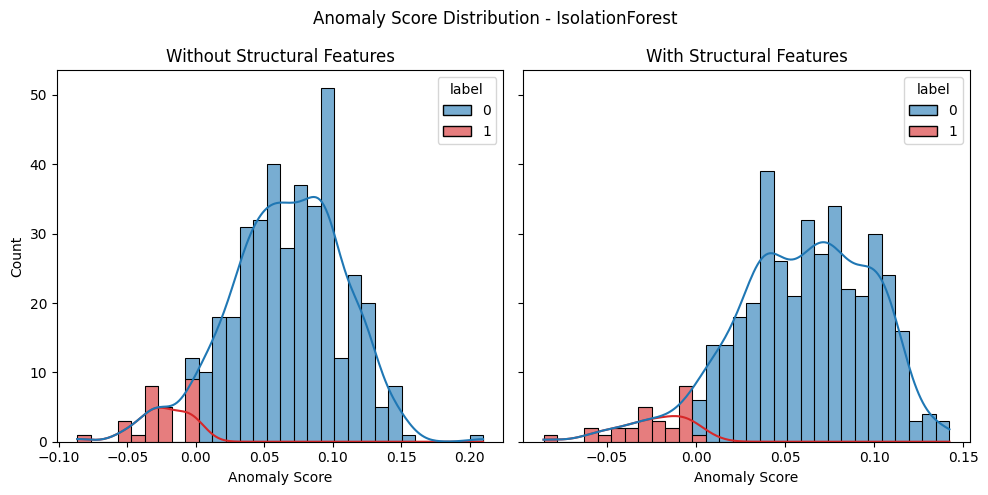

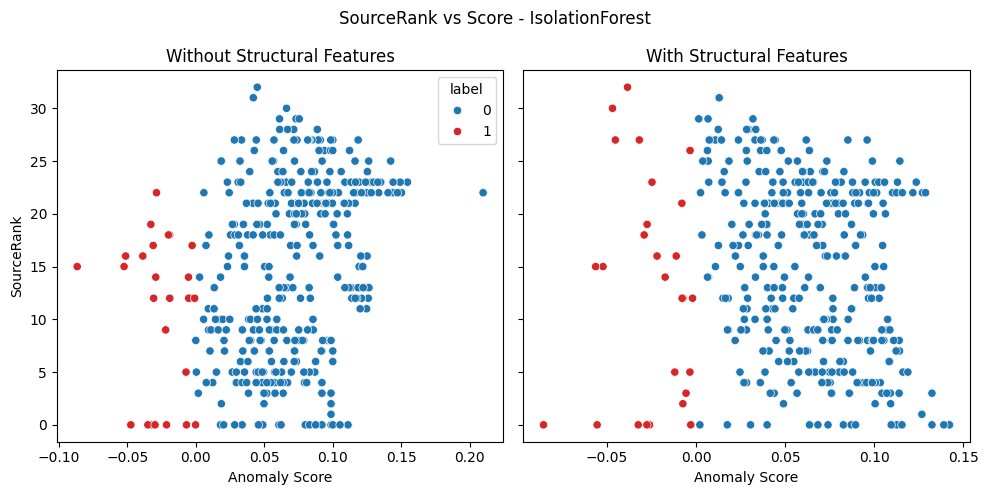

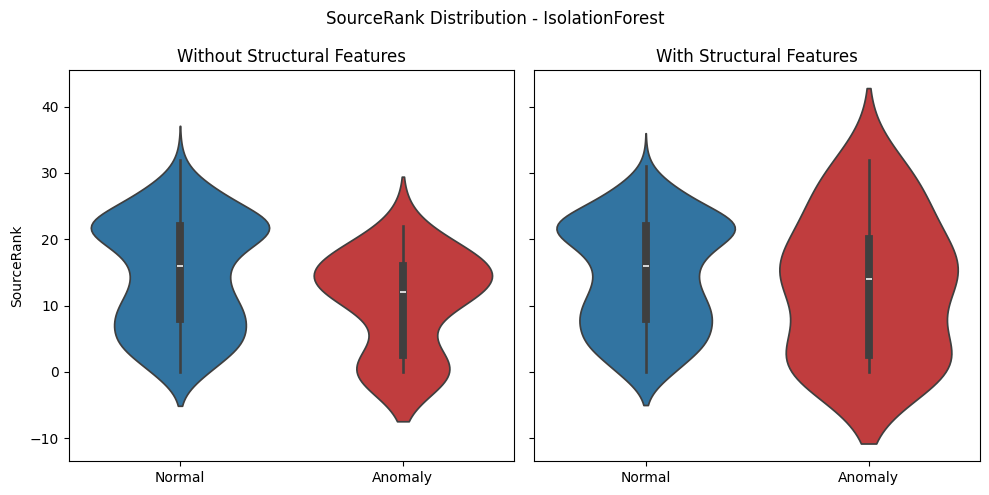

In [129]:
def plot_anomaly_results(df_left, df_right, label, 
                         left_title="Without Structural Features",
                         right_title="With Structural Features",
                         core_only=False):
    palette = {0: "#1f77b4", 1: "#d62728"}
    label_map = {0: "Normal", 1: "Anomaly"}
    dfs = [df_left, df_right]
    titles = [left_title, right_title]

    # If core_only, filter to only core nodes
    if core_only:
        dfs = [df[df["core"] == True] for df in dfs]

    # 1. Histogram: Anomaly Score Distribution
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for i, (df, ax) in enumerate(zip(dfs, axes)):
        sns.histplot(
            data=df, x="score", hue="label", bins=30, kde=True,
            palette=[palette[0], palette[1]], hue_order=[0,1], alpha=0.6, multiple="stack", ax=ax
        )
        ax.set_title(f"{titles[i]}")
        ax.set_xlabel("Anomaly Score")
        ax.set_ylabel("Count")
    plt.suptitle(f"Anomaly Score Distribution - {label}")
    plt.tight_layout()
    plt.show()

    # 2. Scatterplot: SourceRank vs Score
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for i, (df, ax) in enumerate(zip(dfs, axes)):
        sns.scatterplot(
            data=df, x="score", y="SourceRank", hue="label",
            palette=[palette[0], palette[1]], hue_order=[0,1], ax=ax
        )
        ax.set_title(f"{titles[i]}")
        ax.set_xlabel("Anomaly Score")
        ax.set_ylabel("SourceRank")
        if i == 1:
            ax.legend([],[], frameon=False)
    plt.suptitle(f"SourceRank vs Score - {label}")
    plt.tight_layout()
    plt.show()

    # 3. Violinplot: SourceRank per class
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for i, (df, ax) in enumerate(zip(dfs, axes)):
        sns.violinplot(
            data=df, x="label", y="SourceRank", hue="label",
            palette=[palette[0], palette[1]], order=[0,1], inner="box", legend=False, ax=ax
        )
        ax.set_xticks([0,1])
        ax.set_xticklabels([label_map[j] for j in [0,1]])
        ax.set_title(f"{titles[i]}")
        ax.set_xlabel("")
        ax.set_ylabel("SourceRank")
    plt.suptitle(f"SourceRank Distribution - {label}")
    plt.tight_layout()
    plt.show()

plot_anomaly_results(df_iso, df_iso_structural, "IsolationForest", core_only=True)

In [131]:
df = df_iso[df_iso.label == 1].sort_values("score", ascending=False)
df[df.node == "pandas"]

,node,score,label,SourceRank,stars,forks,license,latest_release,num_optional_deps,repo_url,...,is_removed,is_copycat,is_recent,inter_intra_ratio,clustering_coefficient,betweenness_centrality,degree_centrality,closeness_centrality,anomaly_score_IsolationForest,is_anomaly_IsolationForest
142,pandas,-0.047381,1,0,0,0,Unknown,Unknown,79,Unknown,...,0,False,True,0.171429,0.027304,0.006312,0.051958,0.024663,-0.083208,True
